<a href="https://colab.research.google.com/github/JaimeRedondo/Mushrooms_Classification/blob/master/Mushrooms_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#We can search images from Bing, better option because it works.
! pip install bing-image-downloader
! pip install opencv-python
#instalo open cv
from matplotlib import image
from matplotlib import pyplot
from skimage import io
import cv2
import os
! pip install tensorflow

import tensorflow as tf
#Packages
#--Web scraping packages
from bs4 import BeautifulSoup
import requests
#Pandas/numpy for data manipulation
import pandas as pd
import numpy as np
from urllib.request import urlopen
from bing_image_downloader import downloader
from tqdm.notebook import tqdm
from time import sleep 

#import libraries I want.
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input

%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


# Define Functions

Web Scraping to have enough mushrooms types.

In [2]:
def scraping_mushrooms():    
    clean_titles_all=pd.DataFrame()
    titles=['Final']
    url = 'https://www.fungipedia.org/hongos.html?start=0'

    while 'Final' in list(titles):
        html = urlopen(url)
        soup = BeautifulSoup(html, 'lxml')
    
    ## getting the web titles
        titles=[]
        all_links = soup.find_all("a")
        for link in all_links:
            titles.append(link.get("title"))
        
        titles=pd.Series(titles).apply(str)
    
        titles=titles[titles!='None']
    
        titles_df=titles.reset_index()
    
        for phrase in titles_df[0]:
            if phrase =='Catálogo de Setas y Hongos':
                numero=int((titles_df[titles_df[0]==phrase]['index']))
            else:
                continue
            
        titles=titles[titles.index > numero]
    
        clean_titles=titles[titles.str.len()>6][:-1]
    
        clean_titles=clean_titles.to_frame()
    
        siguiente = '='+str(int(url.split('=')[1])+20)
    
        url = url.split('=')[0] + siguiente
    
        clean_titles_all = clean_titles_all.append(clean_titles)
    
    clean_titles_all=clean_titles_all.reset_index()

    del clean_titles_all['index']

    lista_setas = clean_titles_all[0]

    lista_setas=list(lista_setas)
    
    return lista_setas


Download Images From an Internet Browser (Bing)

In [3]:
#keep 1 photo of ecah mushroom,##write a list of things in the input of searcher:
def searcher_downloader(lista):
    for seta in tqdm(lista):
        try:
            downloader.download(seta, limit=20,  output_dir='dataset', 
            adult_filter_off=True, force_replace=False, timeout=60)
        except:
            print("esta no puedo")
    print("I'm done")

Standarize the images downloaded

In [4]:
#estandarizamos nombres de fotos
def standarize_names(directory):
    for folder in tqdm(directory):
        directorio = os.listdir('dataset/'+folder)
        for image in directorio:     
            if image.split('.')[1] == 'jpg':
                continue
            else:
                image_new=image.split('.')[0] + '.jpg'
                os.rename('dataset/'+folder+'/'+image, 'dataset/'+folder+'/'+image_new)

In [5]:
#resize all images shape in 200x200 and print what photos are not available
def resize_photos(directory):
    for folder in tqdm(directory):
        for numero in range(20):
            try:
                route = "dataset/" + folder +'/Image_'+ str(numero+1) + '.jpg'
                data_picture = io.imread(route)
                data_picture = cv2.resize(data_picture, (200, 200))
                # save the images
                cv2.imwrite(route,data_picture)
            except:  
                print("imagen "+str(numero+1)+' de la seta '+folder+' no está disponible')

In [6]:
#standarize 0_255 pixels to 0 - 1.
lista=[]
def standarize_pixels(directory):
    for folder in tqdm(directory):
        for numero in range(20):
            try:
                route = "dataset/" + folder +'/Image_'+ str(numero+1) + '.jpg'
                image_rgb=io.imread(route)/255.0
                lista.append(image_rgb)
            except:
                print(folder+str(numero+1))

In [7]:
def standarize_photos(directory):
    print("renombrando...")
    standarize_names(directory)
    print("homogeneizando tamaño fotos...")
    resize_photos(directory)
    print("estandarizando pixels...")
    standarize_pixels(directory)

In [8]:
def comprobar_longitudes_carpetas(directorio):
    for folder in directorio:
        print(folder + ' '+str(len(os.listdir("dataset/" + folder))))

In [9]:
def plot_mushroom_image(N, imgs, labels):
    print(labels[N])
    plt.imshow(imgs[N,], cmap=plt.cm.binary)
    plt.grid(True)

### Apply the def functions

In [10]:
lista_setas=scraping_mushrooms()

In [11]:
lista_setas_2=lista_setas[0:10]
#primero lo hare con unm muestra

In [12]:
lista_setas_2

['Abortiporus biennis',
 'Adelphella babingtonii',
 'Agaricus arvensis',
 'Agaricus campestris',
 'Agaricus litoralis',
 'Agaricus sylvaticus',
 'Agaricus sylvicola',
 'Agaricus urinascens',
 'Agaricus xanthodermus',
 'Agrocybe praecox']

In [14]:
searcher_downloader(lista_setas_2)



[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://upload.wikimedia.org/wikipedia/commons/2/25/Abortiporus_biennis_197275.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://genome.jgi.doe.gov/public/Abobi1/03.JPG;jsessionid=BA3393281A93E12E8F769D49DDEF7D04
[%] File Downloaded !

[%] Downloading Image #3 from https://upload.wikimedia.org/wikipedia/commons/6/6e/Abortiporus_biennis_179245.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.pinimg.com/originals/d5/1b/4e/d51b4e4665005a5545ec757f5d25edda.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://calphotos.berkeley.edu/imgs/512x768/0000_0000/1109/0479.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://objects.liquidweb.services/images/201612/richard_orr_29822080860_ea30c0a691_b.jpg
[%] File Downloaded !

[%] Downloading Image #7 from https://wpamushroomclub.org/wp-content/uploads/2019/08/Abortiporus-biennis.-By-Erin-Nihiser.jpg
[%] 

In [15]:
contenido = os.listdir('dataset')
contenido=sorted(contenido)
contenido

['Abortiporus biennis',
 'Adelphella babingtonii',
 'Agaricus arvensis',
 'Agaricus campestris',
 'Agaricus litoralis',
 'Agaricus sylvaticus',
 'Agaricus sylvicola',
 'Agaricus urinascens',
 'Agaricus xanthodermus',
 'Agrocybe praecox']

In [16]:
comprobar_longitudes_carpetas(contenido)

Abortiporus biennis 20
Adelphella babingtonii 20
Agaricus arvensis 20
Agaricus campestris 20
Agaricus litoralis 20
Agaricus sylvaticus 20
Agaricus sylvicola 20
Agaricus urinascens 20
Agaricus xanthodermus 20
Agrocybe praecox 20


In [17]:
standarize_photos(contenido)

renombrando...



homogeneizando tamaño fotos...



estandarizando pixels...


In [148]:
train_images=np.array(lista)
train_images.shape

(200, 200, 200, 3)

In [149]:
lista_categories=[]
for folder in tqdm(contenido):
    for i in range(20):
        lista_categories.append(folder)
        
train_labels=np.array(lista_categories)

In [150]:
len(train_labels)

200

In [151]:
test_labels=[]
for element in range(0,len(train_labels),20):
  test_labels.append(train_labels[element])
  test_labels.append(train_labels[element+1])

In [152]:
test_images=[]
for element in range(0,len(train_images),20):
  test_images.append(train_images[element])
  test_images.append(train_images[element+1])

In [153]:
len(train_images)

200

In [154]:
len(train_labels)

200

In [155]:
test_labels

['Abortiporus biennis',
 'Abortiporus biennis',
 'Adelphella babingtonii',
 'Adelphella babingtonii',
 'Agaricus arvensis',
 'Agaricus arvensis',
 'Agaricus campestris',
 'Agaricus campestris',
 'Agaricus litoralis',
 'Agaricus litoralis',
 'Agaricus sylvaticus',
 'Agaricus sylvaticus',
 'Agaricus sylvicola',
 'Agaricus sylvicola',
 'Agaricus urinascens',
 'Agaricus urinascens',
 'Agaricus xanthodermus',
 'Agaricus xanthodermus',
 'Agrocybe praecox',
 'Agrocybe praecox']

In [156]:
train_images, train_labels=list(train_images),list(train_labels)

In [157]:
lista_nueva_images=[]
for element in range(0,len(train_images),20):
  lista_partida = train_images[element:element+20]
  lista_partida = lista_partida[2:]
  lista_nueva_images.append(lista_partida)

lista_nueva_images = [item for lista in lista_nueva_images for item in lista]

len(lista_nueva_images)

180

In [158]:
lista_nueva_labels=[]
for element in range(0,len(train_labels),20):
  lista_partida = train_labels[element:element+20]
  lista_partida = lista_partida[2:]
  lista_nueva_labels.append(lista_partida)

lista_nueva_labels = [item for lista in lista_nueva_labels for item in lista]

len(lista_nueva_labels)

180

In [159]:
#transformamos otra vez a arrays los datos de train y de test

train_images, train_labels, test_images, test_labels = np.array(lista_nueva_images), np.array (lista_nueva_labels), np.array(test_images), np.array(test_labels)

In [162]:
test_images.shape

(20, 200, 200, 3)

Agaricus arvensis


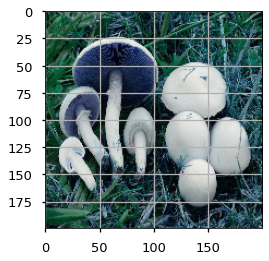

In [163]:
plot_mushroom_image(39,train_images,train_labels)

In [164]:
train_labels.shape
#cambiar formato nombres para que funcionen

(180,)

In [166]:
np.unique(train_labels)

array(['Abortiporus biennis', 'Adelphella babingtonii',
       'Agaricus arvensis', 'Agaricus campestris', 'Agaricus litoralis',
       'Agaricus sylvaticus', 'Agaricus sylvicola', 'Agaricus urinascens',
       'Agaricus xanthodermus', 'Agrocybe praecox'], dtype='<U22')

In [167]:
l1 = list(range(10))
l2 = list(np.unique(train_labels))
d = dict(zip(l1,l2))
#create a dictionary to use one hot encoder

In [168]:
d

{0: 'Abortiporus biennis',
 1: 'Adelphella babingtonii',
 2: 'Agaricus arvensis',
 3: 'Agaricus campestris',
 4: 'Agaricus litoralis',
 5: 'Agaricus sylvaticus',
 6: 'Agaricus sylvicola',
 7: 'Agaricus urinascens',
 8: 'Agaricus xanthodermus',
 9: 'Agrocybe praecox'}

In [173]:
train_labels_nums = sorted(list(d.keys())*20)

test_labels_nums = sorted(list(d.keys())*2)

In [176]:
len(test_labels_nums), len(train_labels_nums)

(20, 200)

Transform to one hot encoder the 10 classes we hace for now

In [177]:
#transformamos a onehot nuestros targets 
onehot_train=to_categorical(train_labels_nums,num_classes=10)


onehot_test=to_categorical(test_labels_nums,num_classes=10)

onehot_train.shape,onehot_test.shape

((200, 10), (20, 10))

Vamos a crear nuestra primera red neuronal

In [178]:
def build():
  m = models.Sequential()

#le decimos el input para que el output 

  l0 = layers.Flatten(input_shape=(200,200,3))
  m.add(l0)

  l1 = layers.Dense(units=50, activation = 'relu')
  m.add(l1)

  l2 = layers.Dense(units=25, activation = 'relu')
  m.add(l2)

  l3 = layers.Dense(units=15, activation = 'relu')
  m.add(l3)

  l4 = layers.Dense(units=10, activation = 'softmax')
  m.add(l4)

  
#ponemos none, ya no hace falta relu al ser una , decir que por defecto ya seria none.

#numero random el 3 por ejemoplo que es el numero de neuronas a la salida

  m.summary()

  return m

In [179]:
m=build()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6000050   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                160       
Total params: 6,001,875
Trainable params: 6,001,875
Non-trainable params: 0
_________________________________________________________________


In [180]:
m.compile(optimizer=optimizers.Adam(),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

In [181]:
train_images.shape

(180, 200, 200, 3)

In [182]:
onehot_train.shape

(200, 10)

In [183]:
 h = m.fit (train_images,onehot_train,batch_size= 5,epochs=30,validation_split=0.1)

Epoch 1/30
33/33 [==============================] - 2s 38ms/step - loss: 13.6486 - categorical_accuracy: 0.1734 - val_loss: 11.2676 - val_categorical_accuracy: 0.0000e+00
Epoch 2/30
33/33 [==============================] - 1s 30ms/step - loss: 2.4248 - categorical_accuracy: 0.1277 - val_loss: 3.1544 - val_categorical_accuracy: 0.0000e+00
Epoch 3/30
33/33 [==============================] - 1s 30ms/step - loss: 2.2444 - categorical_accuracy: 0.1244 - val_loss: 3.6414 - val_categorical_accuracy: 0.0000e+00
Epoch 4/30
33/33 [==============================] - 1s 30ms/step - loss: 2.1212 - categorical_accuracy: 0.1395 - val_loss: 3.1558 - val_categorical_accuracy: 0.0000e+00
Epoch 5/30
33/33 [==============================] - 1s 30ms/step - loss: 2.1279 - categorical_accuracy: 0.2302 - val_loss: 4.0488 - val_categorical_accuracy: 0.0000e+00
Epoch 6/30
33/33 [==============================] - 1s 30ms/step - loss: 2.0658 - categorical_accuracy: 0.1656 - val_loss: 3.6388 - val_categorical_accur

In [185]:
m.evaluate(test_images,onehot_test)

1/1 [==============================] - 0s 26ms/step - loss: 2.7683 - categorical_accuracy: 0.2500


[2.768315553665161, 0.25]